# Introduction

In the first portion of this assignment 3 walkthrough, we rely on a popular NLP library [spaCy](https://spacy.io/) to create knowledge graphs.

In order to do this, we use the gramatical rules about sentence composition encoded in spaCy.

We begin by downloading the English lexicon.


In [1]:
#! python -m spacy download en_core_web_lg

We will use the [networkx](https://networkx.org/) library to plot the knowledge graphs created for the movie reviews. 

In [2]:
import spacy

import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from spacy.matcher import Matcher 

from tqdm import tqdm

In [3]:
sns.set_context('talk')

In [4]:
# Sometimes the path of the downloaded spacy model doesn't get picked on Colab
# This cell needs to be executed in such situations
# Use this only if spacy.load(...) is failing in the next step

import spacy.cli

#spacy.cli.download("en_core_web_lg")

In [5]:
nlp = spacy.load('en_core_web_lg')

In [6]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

# Data

In [7]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv'
class_corpus = get_corpus_df(CORPUS_PATH)

In [8]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 40 to 199
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB


In [9]:
class_corpus.Text.head()

Doc_ID
40    Boredom sets in long before the start of Angel...
41    \nWho ARE all these people?\n\nThat was what...
42    Ric Roman Waughs Angel Has Fallen sees U.S. S...
43    There is a certain mindless pleasure in the Fa...
44    No, you dont need to have seen Olympus Has F...
Name: Text, dtype: object

In [10]:
class_corpus['Movie Title'].value_counts()

Angel Has Fallen     10
Inception            10
Oblivion             10
Minority Report      10
Equilibrium          10
Batman               10
US                   10
The Toxic Avenger    10
It Chapter Two       10
Fresh                10
Drag me to hell      10
The Lost City        10
Legally Blonde       10
Holmes and Watson    10
Dirty Grandpa        10
Despicable Me 3      10
Taxi                 10
Taken                10
No Time To Die       10
Pitch Black          10
Name: Movie Title, dtype: int64

Creation of knowledge graphs rests on two crucial ingredients.  
- entities that represent specific concepts
- relations that connect different concepts

Translated into the rules of English, [the hypothesis](https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook) is that for each sentence:
 - entities are the subject and object in the sentence
 - verbs encode the relation between the entities in the sentence
 - entities could be compound words (e.g., phrases)  

In [11]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " " + prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                   {'DEP':'prep', 'OP':"?"},
                   {'DEP':'agent', 'OP':"?"},  
                   {'POS':'ADJ', 'OP':"?"}] 
        
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except Exception as e:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

As the above code listing indicates, we use spaCy's grammatical annotations for the tokens (indicated by `dep_`) to identify the relevant parts of speech.

In [12]:
spacy.explain('agent')

'agent'

For this part of the assignment, we work on a set of reviews for one movie.

In [13]:
MOVIE_TO_EXPLORE = 'Taxi'

In [14]:
movie_reviews = (class_corpus.loc[class_corpus['Movie Title'] == MOVIE_TO_EXPLORE, 'Text']
                             .reset_index(drop=True))

# Example Review

Let us see how the entity and relation functions work on an example sentence from the set of 10 reviews.

## Explore entities & relations

In [15]:
movie_reviews

0    Jimmy Fallon's big screen career may be over b...
1    Queen Latifah handily walked away with the sho...
2    So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...
3    TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...
4    Jimmy Fallon needs to call Tina Fey and beg he...
5    After getting nominated for "Chicago" and maki...
6    How one likes "Taxi" has everything to do with...
7    ChicagoÕs Queen Latifah andÊSaturday Night Liv...
8    After five years of waiting, Belle Williams (Q...
9    On her first day as a taxi driver, the wild Be...
Name: Text, dtype: object

In [16]:
movie_reviews[1]

'Queen Latifah handily walked away with the show inÊChicago. She enlivened the unevenÊBringing Down the House. Her scenes inÊBarbershop 2Êwere among the filmÕs highlights. So what is it with her and these steaming piles of donkey crap likeÊThe CookoutÊand the dreadfully unfunny, unexciting, uninspired and occasionally offensiveÊTaxi? I have to confess that I took a little nap during the middle stretch of the film, but that may be the only reason IÕm willing to give it a half-star edge over Hilary DuffÕs vehicle of destruction,ÊRaise Your Voice.ÊTaxiÊwas at least more restful, but in its own way, it may actually be a worse movie, since it wastes not only Queen Latifah, but also the rightly legendary Ann-Margret. If youÕve seen the filmÕs lackluster trailer Ñ complete with the bewhiskered tag line, ÒHeÕs armed, but sheÕs dangerousÓ Ñ youÕve seen the film. All youÕve missed is 95 minutes of padding. IÕve never seen the original French film (also produced by Luc Besson), but IÕm hard-press

In [17]:
doc = nlp(movie_reviews[1])

Passing a review through the `nlp` pipeline from `spaCy` automatically generates a set of sentences in the review. This is accessed by the attribute `sents`.

In [18]:
list(doc.sents)

[Queen Latifah handily walked away with the show inÊChicago.,
 She enlivened the unevenÊBringing Down the House.,
 Her scenes inÊBarbershop 2Êwere among the filmÕs highlights.,
 So what is it with her and these steaming piles of donkey crap likeÊThe CookoutÊand the dreadfully unfunny, unexciting, uninspired and occasionally offensiveÊTaxi?,
 I have to confess that I took a little nap during the middle stretch of the film, but that may be the only reason IÕm willing to give it a half-star edge over Hilary DuffÕs vehicle of destruction,ÊRaise Your Voice.,
 ÊTaxiÊwas at least more restful, but in its own way, it may actually be a worse movie, since it wastes not only Queen Latifah, but also the rightly legendary Ann-Margret.,
 If youÕve seen the filmÕs lackluster trailer Ñ complete with the bewhiskered tag line, ÒHeÕs armed, but sheÕs dangerousÓ Ñ youÕve seen the film.,
 All youÕve missed is 95 minutes of padding.,
 IÕve never seen the original French film (also produced by Luc Besson), b

In [19]:
doc_sents = [str(x) for x in list(doc.sents)]

Let us pick the first sentence to observe how the entity-relation extraction works.

In [20]:
example_sent = doc_sents[0]

In [21]:
example_sent

'Queen Latifah handily walked away with the show inÊChicago.'

Vanilla application of the `get_subject_verb_object` function does not yield a good result since theer could be compound entities.

In [22]:
get_subject_verb_object(example_sent)

['Latifah', 'walked', '']

Passing the example sentence to the `nlp` pipeline extracts the parts of speech in the sentence.

In [23]:
example_nlp = nlp(example_sent)

In [24]:
for tok in example_nlp:
    print(tok.dep_)

compound
nsubj
advmod
ROOT
advmod
prep
det
compound
pobj
punct


In [25]:
spacy.explain('punct')

'punctuation'

In [26]:
get_entities(example_sent)

['Queen Latifah', 'away show inÊChicago']

In [27]:
get_relation(example_sent)

'walked'

We can now parse through all the sentences in the review and extract the entities and relations.

In [28]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 41/41 [00:00<00:00, 81.86it/s]


In [29]:
entity_pairs

[['Queen Latifah', 'away show inÊChicago'],
 ['She', 'House'],
 ['scenes', 'filmÕs highlights'],
 ['So  it', 'steaming crap likeÊThe CookoutÊand'],
 ['middle  that', 'half Hilary Voice'],
 ['worse  it', 'only Queen Latifah'],
 ['sheÕs dangerousÓ Ñ youÕve', 'film'],
 ['missed', '95  padding'],
 ['three turkey dinner isnÕt', 'also Luc Besson'],
 ['Hollywood filmmaking', 'new  desperation'],
 ['story line', ''],
 ['stupidest  who', 'stupidest  cop'],
 ['himself', 'souped driver Queen robbery'],
 ['already  Queen', 'already  road'],
 ['double  Ñ', 'last bike messenger'],
 ['her', 'first taxi jobs'],
 ['Ñ', 'squealing PG-13 rating'],
 ['better  he', 'bland  Fallon'],
 ['why  I', 'odd buddy bondings ensues'],
 ['absolutely  none', 'small  Fallon'],
 ['', 'heÕs'],
 ['I', 'as box office draw'],
 ['free home they', 'actually  money'],
 ['Fallon', 'film'],
 ['next Julia Sweeney', ''],
 ['when theÊItÕs it', 'Natalie Cole impression'],
 ['Fallon', 'only  ointment'],
 ['simply director Tim Story', 

In [30]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 41/41 [00:00<00:00, 81.75it/s]


In [31]:
relations

['walked',
 'enlivened',
 'inÊBarbershop 2Êwere',
 'is',
 'have',
 'ÊTaxiÊwas',
 'seen',
 'is',
 'seen',
 'be',
 'is weak',
 'stars as',
 'finds',
 'know',
 'suggests',
 'see',
 'motherÉÓ',
 'proves',
 'One of',
 'suppose',
 'Beyond',
 'see',
 'learned',
 'say',
 'be nearer',
 'be in',
 'is',
 'coasts on',
 'shown',
 'Ñ',
 'is typical',
 'fall on',
 'is',
 'and',
 'Kouf',
 'is',
 'is',
 'have',
 'seems in',
 'ÊTaxiÊreaches',
 'be sure']

To visualize the knowledge graph we create a data frame with the source and target mapped out with the relationship between them (referred to as an edge-list).

In [32]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 
                      'target': target, 
                      'edge': relations})

In [33]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

Knowledge graph for one review.

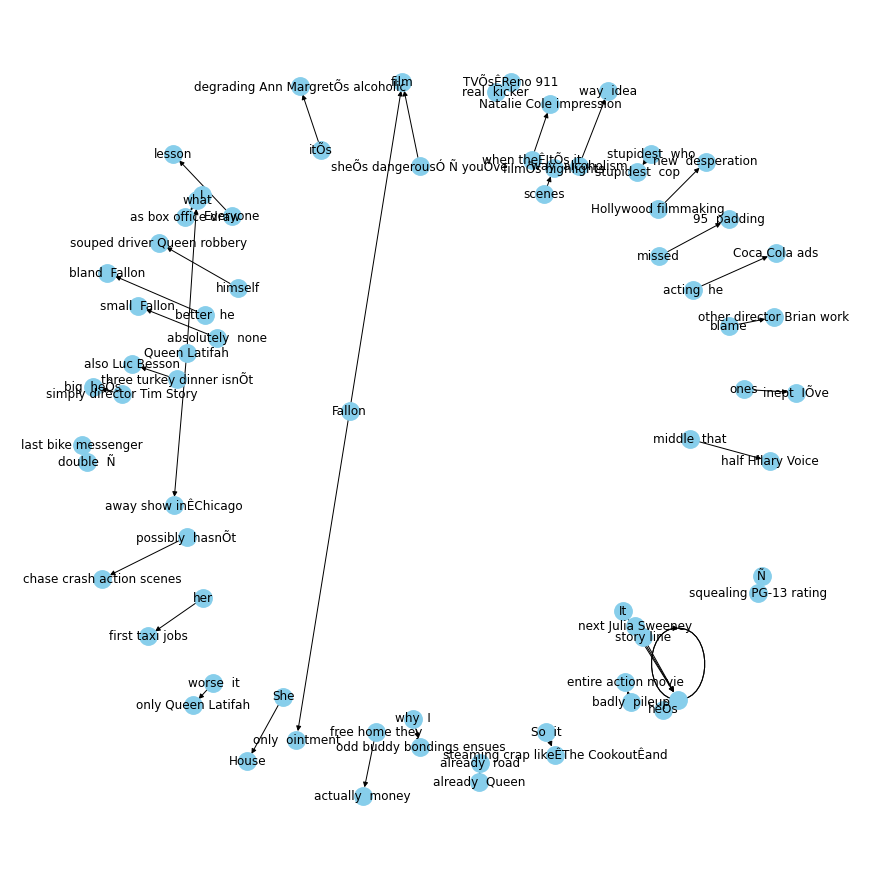

In [34]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)

plt.show()

# All Reviews

So far we have worked with one review. We can now roll out the same method to plot the knowledge graph for the 10 reviews collected for the chosen movie.

## Explore entities and relations

In [35]:
movie_reviews

0    Jimmy Fallon's big screen career may be over b...
1    Queen Latifah handily walked away with the sho...
2    So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...
3    TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...
4    Jimmy Fallon needs to call Tina Fey and beg he...
5    After getting nominated for "Chicago" and maki...
6    How one likes "Taxi" has everything to do with...
7    ChicagoÕs Queen Latifah andÊSaturday Night Liv...
8    After five years of waiting, Belle Williams (Q...
9    On her first day as a taxi driver, the wild Be...
Name: Text, dtype: object

Conceptually, this is no different from working on one review, we simply join all the reviews for the movie into one large string.

In [36]:
all_movie_reviews = ' '.join(movie_reviews)

In [37]:
doc = nlp(all_movie_reviews)

In [38]:
doc_sents = [str(x) for x in doc.sents]

First sentence

In [39]:
doc_sents[0]

"Jimmy Fallon's big screen career may be over before it even gets started if his complete lack of screen presence inÊTaxiÊis any indication."

Last sentence

In [40]:
doc_sents[-1]

'Do not miss the credits, with the hilarious errors of the scene.'

In [41]:
len(doc_sents)

271

In [42]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 271/271 [00:03<00:00, 76.76it/s]


In [43]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 271/271 [00:03<00:00, 72.22it/s]


In [44]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [45]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [46]:
kg_df.shape

(240, 3)

In [47]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, create_using=nx.MultiDiGraph())

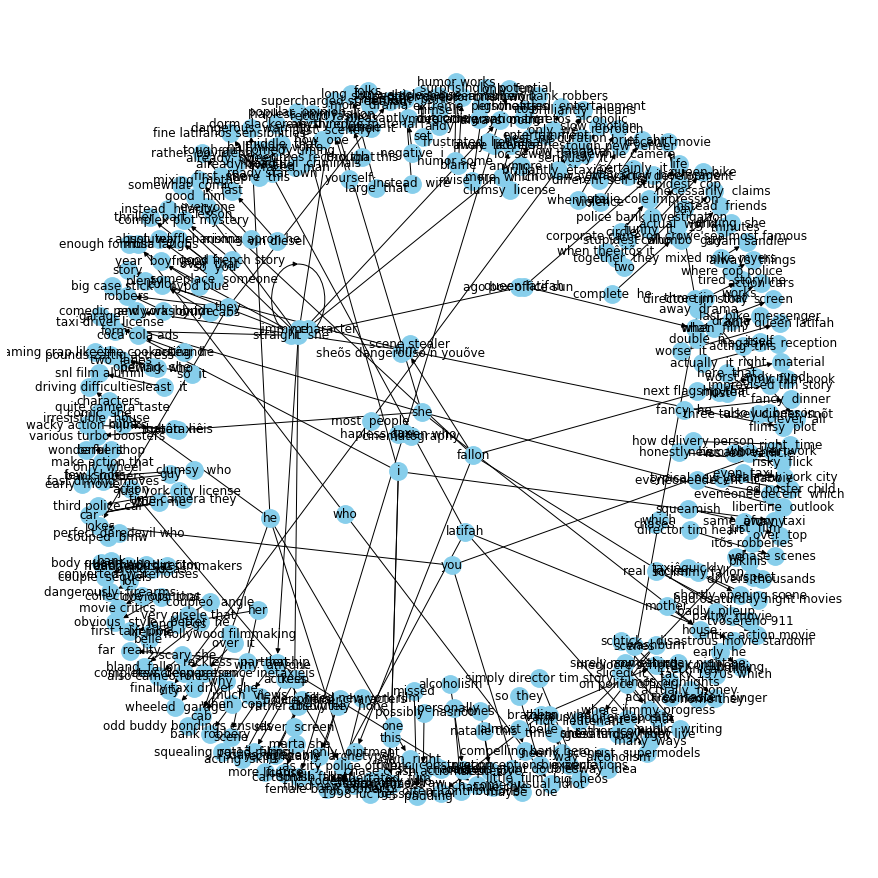

In [48]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)

plt.show()

## Interesting relations

There are several relations to explore in the plot from the previous section. We could choose to focus on some relations that we find are particularly interesting.

In [49]:
pd.Series(relations).value_counts()[:50]

is                  35
's                  19
are                  8
be                   6
has                  6
left                 5
have                 4
was                  4
had                  3
make                 3
seen                 3
takes                3
plays                3
shown                2
see                  2
notice               2
get                  2
leaves               2
say                  2
gives                2
commandeers          2
makes                2
finds                2
stars as             2
seems                2
be overwhelming      1
'm happy             1
throw                1
team                 1
Latifah              1
liked                1
alumni               1
expect different     1
matches              1
tolerate             1
seem                 1
enjoyed              1
go by                1
loves                1
hops into            1
comes                1
sees                 1
are enough           1
do         

We could zoom in on interesting relations from the list above.

In [78]:
RELATION_TO_EXPLORE = 'know'

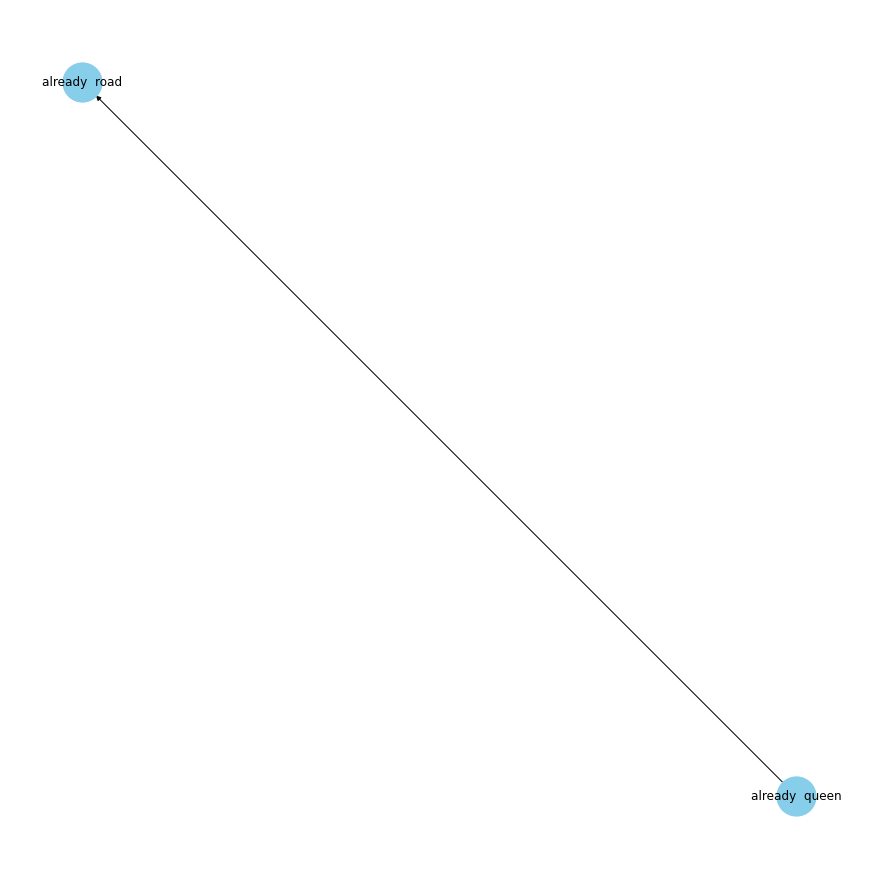

In [79]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

## Interesting entities

Similary, we could zoom in on interesting entitites (say those identified from the manual ontology creation).

In [89]:
ENTITY_TO_EXPLORE = 'fallon'

In [90]:
entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)

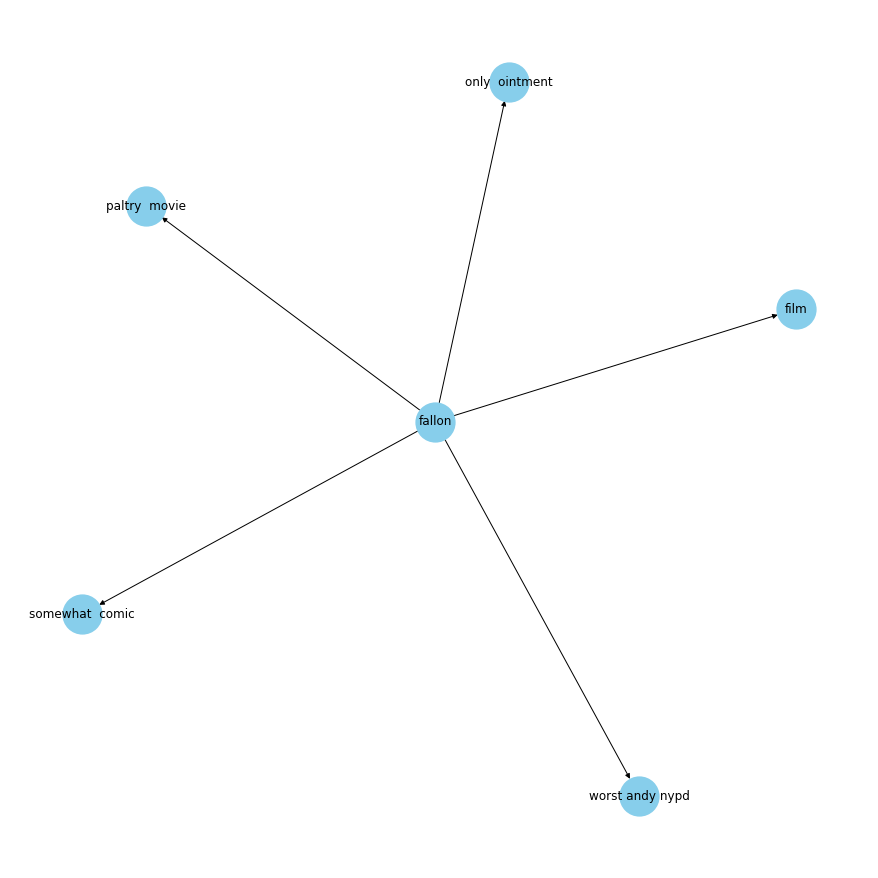

In [91]:
G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

# Next Steps

- Identify and merge equivalence classes in the entities extracted.
- Explore few interesting relations and entities.

# Reference

https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook